In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

# Step 1: no learning rule

Here's just the basic setup with two neurons and we can look at the spikes and membrane voltage.  The `stim_pre` and `stim_post` give regular pulses of input.  I've adjusted the post-synaptic neuron to have a membrane time constant of 100ms, just so we can see the membrane voltage decay slowly.

In [52]:
model = nengo.Network()
with model:
    pre = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0])
    post = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0],
                          neuron_type=nengo.LIF(tau_rc=0.1))
    
    stim_pre = nengo.Node(lambda t: 1 if 0.2<t%0.4<0.3 else 0)
    stim_post = nengo.Node(lambda t: 1 if 0.25<t%0.4<0.35 else 0)
    nengo.Connection(stim_pre, pre, synapse=None)
    nengo.Connection(stim_post, post, synapse=None)
    
    
    p_stim_pre = nengo.Probe(stim_pre)
    p_stim_post = nengo.Probe(stim_post)
    
    p_pre = nengo.Probe(pre.neurons)
    p_post = nengo.Probe(post.neurons)
    p_post_v = nengo.Probe(post.neurons, 'voltage')
    
sim = nengo.Simulator(model)
sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

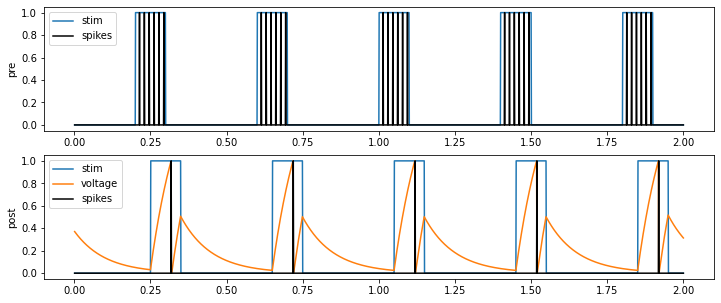

In [54]:
plt.figure(figsize=(12,5))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim_pre], label='stim')
plt.plot(sim.trange(), sim.data[p_pre]/1000, c='k', label='spikes')
plt.ylabel('pre')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_stim_post], label='stim')
plt.plot(sim.trange(), sim.data[p_post_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_post]/1000, c='k', label='spikes')
plt.ylabel('post')
plt.legend()


# Step 2: Add a learning rule

Now we add a Node that implements the learning rule.  To organize the Node a bit better (and have a place to store the weights), I'm using a `nengo.Process`, which is just a slightly fancier way of specifying the function for a Node.

The weird "signal" thing is how we're accessing the membrane voltage.  Since there isn't a way right now to have that data be passed by a Connection, we're just hacking into the internals of Nengo to get that information.

For simplicity, this just implements a very simple learning rule where `dw = vmem`.  I also multiply by dt just to keep it scaled down, and multiply by x so that it only happens when there's a pre-synaptic spike.

In [55]:
class CustomRule(nengo.Process):
    def __init__(self, vthp=0.25, vthn=0.15, vprog=0.9):
        self.vthp = vthp
        self.vthn = vthn
        self.vprog = vprog
        
        self.signal = None
        
        super().__init__()
        
    def make_step(self, shape_in, shape_out, dt, rng, state=None):  
        self.w = np.zeros((shape_out[0], shape_in[0]))
        
        def step(t, x):
            assert self.signal is not None
            vmem = self.signal[0]
            
            # fill in the adjustment to the weight here
            # x is the spiking output of the pre-synaptic neurons so you can determine which neuron spiked
            
            # here's a really simple hebbian rule, as an example
            dw = x*vmem*dt
            
            self.w += dw
            
            
            return np.dot(self.w, x)
        return step
    
    def set_signal(self, signal):
        self.signal = signal
        
        
model = nengo.Network()
with model:
    pre = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0])
    post = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=[[1]], gain=[2], bias=[0],
                          neuron_type=nengo.LIF(tau_rc=0.1))
    
    stim_pre = nengo.Node(lambda t: 1 if 0.2<t%0.4<0.3 else 0)
    stim_post = nengo.Node(lambda t: 1 if 0.25<t%0.4<0.35 else 0)
    nengo.Connection(stim_pre, pre, synapse=None)
    nengo.Connection(stim_post, post, synapse=None)
    
    w = nengo.Node(CustomRule(), size_in=1, size_out=1)
    nengo.Connection(pre, w, synapse=None)
    nengo.Connection(w, post, synapse=None)
    
    
    p_stim_pre = nengo.Probe(stim_pre)
    p_stim_post = nengo.Probe(stim_post)
    
    p_pre = nengo.Probe(pre.neurons)
    p_post = nengo.Probe(post.neurons)
    p_post_v = nengo.Probe(post.neurons, 'voltage')
    
sim = nengo.Simulator(model)
w.output.set_signal(sim.signals[sim.model.sig[post.neurons]["voltage"]])
sim.run(2)        

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

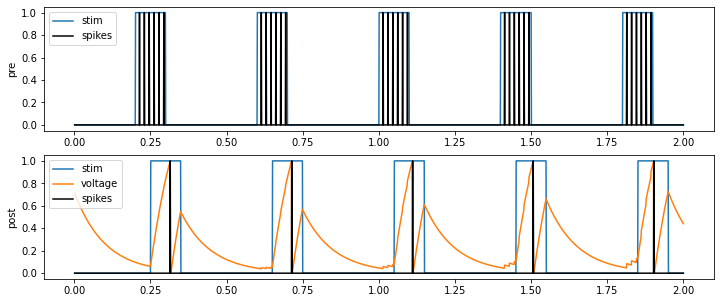

In [56]:
plt.figure(figsize=(12,5))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim_pre], label='stim')
plt.plot(sim.trange(), sim.data[p_pre]/1000, c='k', label='spikes')
plt.ylabel('pre')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_stim_post], label='stim')
plt.plot(sim.trange(), sim.data[p_post_v], label='voltage')
plt.plot(sim.trange(), sim.data[p_post]/1000, c='k', label='spikes')
plt.ylabel('post')
plt.legend()


Notice that you can now see the effects of the spike changing the connection weight (the sudden jumps in the orange line when the pre-synaptic neuron spikes).